# Group Final Report: Predicting Student Placement Outcomes Using Logistic Regression
#### STAT 301, April 2025
#### Paridhi Bansal, Xuyang Chen, Vaibhav Hari, Zhengxi Yuan

## Introduction

## Methods and Results

In [1]:
library(tidyverse)
library(broom)
library(rsample)
library(car)
library(caret)
library(glmnet)
library(pROC)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loa

### a) Data
The dataset contains 10,000 observations and 12 variables related to students' placement status. Each row represents a single student. It includes numeric variables such as CGPA, internships, projects, and test scores, as well as categorical variables like extracurricular activities and placement status. The primary goal of the dataset is to provide insights into how various academic and extracurricular factors might influence whether a student is placed.

- Number of observations: 10000
- StudentID (Integer, numeric) - It is a unique identifier for each student.
- CGPA (Integer, numeric) - It is the overall grades achieved by the student.
- Internships (Float/Double, numeric) - It tells the number of internships a student has done.
- Projects (Integer, numeric) - Number of projects a student has done.
- Workshops/Certifications (Integer, numeric) - As there are multiple courses available online student opt for them to upskill themselves.
- ApptitudeTestScore (Integer, numeric) - Aptitude test are generally a part of the recruitment process to understand the Quant and logical thinking of the student.
- SoftSkillrating (Float/Double, numeric) - Communication is a key role that plays in the placement or in any aspect of the life.
- ExtraCurricularActivities (Character, categorical) - This helps provide and insight about the personality of an individual regarding how much he is active other than the academic.
- PlacementTraining (Character, categorical) - It is provided to students in college to ace the placement process.
- SSC (Integer, numeric) - Senior Secondary Marks.
- HSC (Integer, numeric) - Higher Secondary Marks.
- PlacementStatus (Character, categorical) - This is our target column with two classes placed and not placed.

#### Pre-selection of variables
We'll not use StudentID as an explanatory variable because it is merely a unique identifier for each student and does not carry any meaningful information about their placement status. 

#### Load the Dataset

In [2]:
# Load the dataset
placement_data <- read_csv("https://raw.githubusercontent.com/Sunnie568/STAT-301-group-project/refs/heads/main/data/placementdata.csv")

Rows: 10000 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ExtracurricularActivities, PlacementTraining, PlacementStatus
dbl (9): StudentID, CGPA, Internships, Projects, Workshops/Certifications, A...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Reference
#### Sources
- Dataset: Kumbhar, Ruchika. "Placement Prediction Dataset." Kaggle, https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data.
- Model Training Reference: GeeksforGeeks, Train a Model Using CatBoost, https://www.geeksforgeeks.org/train-a-model-using-catboost/.

#### Collection Methodology
The dataset was likely collected from academic records and placement training programs, which reflects real-world student placement outcomes.
More details on training a machine learning model (e.g., CatBoost) for placement prediction can be found at GeeksforGeeks: https://www.geeksforgeeks.org/train-a-model-using-catboost/.

### b) Exploratory Data Analysis (EDA)

In [3]:
# Drop StudentID and convert categorical variables to factors
placement_data <- placement_data %>% 
select(-StudentID) %>%
  mutate(
    PlacementStatus = factor(PlacementStatus, levels = c("NotPlaced", "Placed")),
    ExtracurricularActivities = factor(ExtracurricularActivities, levels = c("No", "Yes")),
    PlacementTraining = factor(PlacementTraining, levels = c("No", "Yes"))
  )

head(placement_data)

# Check for missing values
sum(is.na(placement_data))

# View dataset structure
str(placement_data)

CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed
7.0,0,2,2,71,4.2,Yes,No,55,66,NotPlaced


[1] 0

tibble [10,000 × 11] (S3: tbl_df/tbl/data.frame)
 $ CGPA                     : num [1:10000] 7.5 8.9 7.3 7.5 8.3 7 7.7 7.7 6.5 7.8 ...
 $ Internships              : num [1:10000] 1 0 1 1 1 0 1 2 1 1 ...
 $ Projects                 : num [1:10000] 1 3 2 1 2 2 1 1 1 3 ...
 $ Workshops/Certifications : num [1:10000] 1 2 2 2 2 2 1 0 0 2 ...
 $ AptitudeTestScore        : num [1:10000] 65 90 82 85 86 71 76 85 84 79 ...
 $ SoftSkillsRating         : num [1:10000] 4.4 4 4.8 4.4 4.5 4.2 4 3.5 3.9 4.4 ...
 $ ExtracurricularActivities: Factor w/ 2 levels "No","Yes": 1 2 2 2 2 2 1 2 1 2 ...
 $ PlacementTraining        : Factor w/ 2 levels "No","Yes": 1 2 1 2 2 1 1 2 2 2 ...
 $ SSC_Marks                : num [1:10000] 61 78 79 81 74 55 62 59 75 85 ...
 $ HSC_Marks                : num [1:10000] 79 82 80 80 88 66 65 72 71 86 ...
 $ PlacementStatus          : Factor w/ 2 levels "NotPlaced","Placed": 1 2 1 2 2 1 1 1 1 2 ...


#### Visualizations

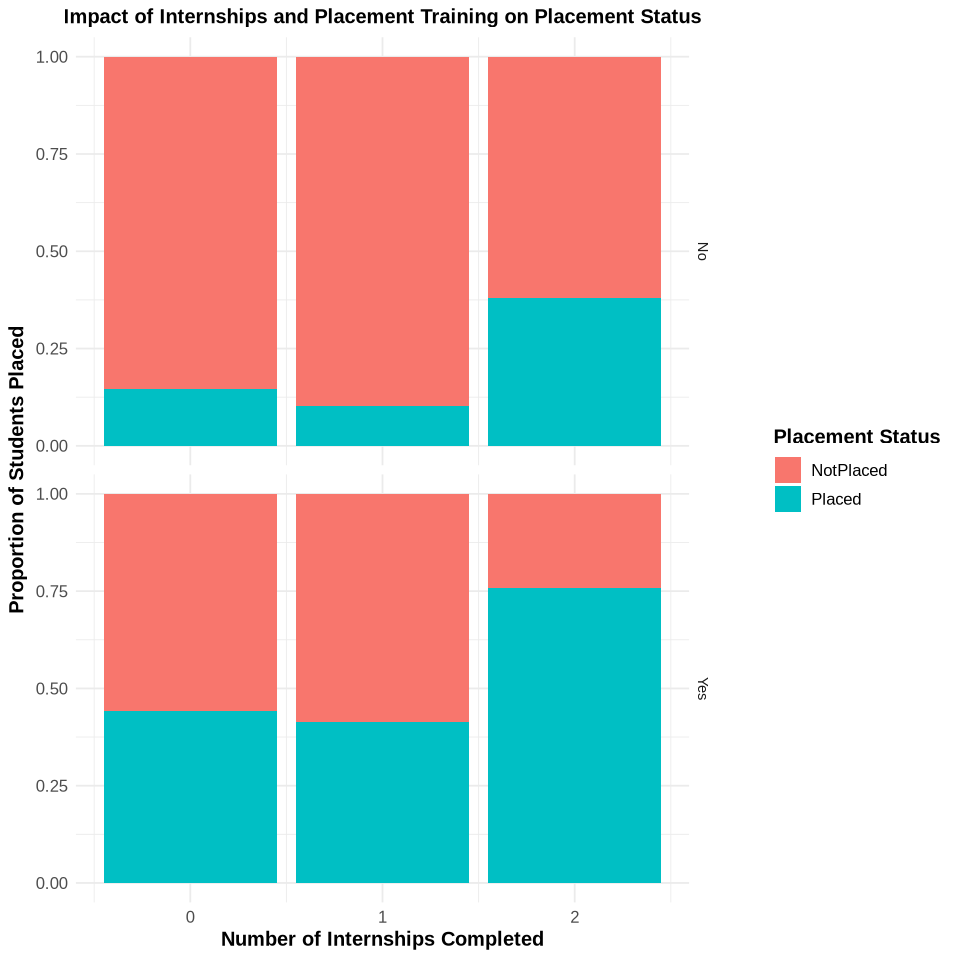

In [4]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(placement_data, aes(x = Internships, fill = PlacementStatus)) +
  geom_bar(position = "fill") +
    facet_grid("PlacementTraining") +
  labs(
    title = "Impact of Internships and Placement Training on Placement Status",
    x = "Number of Internships Completed",
    y = "Proportion of Students Placed",
    fill = "Placement Status",
  ) +
    theme_minimal() +
    theme(
        legend.title = element_text(size = 12, face = "bold"),
        legend.text = element_text(size = 10),
        legend.position = "right",
        legend.box.spacing = unit(1, "cm"),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text = element_text(size = 10),
        plot.title = element_text(size = 12, face = "bold", hjust = 0.5)
    )

- Placement Status (Response Variable)
- Number of Internships (X-axis)
- Placement Training (Row Facet)

In [7]:
# 1. Split data into two parts
df_placed <- placement_data %>% filter(PlacementStatus == "Placed")
df_not_placed <- placement_data %>% filter(PlacementStatus == "NotPlaced")

# 2. Create a correlation matrix for Placed and NotPlaced students
corr_matrix_placed <- 
    df_placed %>%
    select(where(is.numeric)) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_placed)

corr_matrix_not_placed <- 
    df_not_placed %>%
    select(where(is.numeric)) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_not_placed)

var1,var2,corr
<chr>,<chr>,<dbl>
CGPA,CGPA,1.0000000
CGPA,Internships,0.2347647
CGPA,Projects,0.3152994
CGPA,Workshops/Certifications,0.2773790
CGPA,AptitudeTestScore,0.3593718
CGPA,SoftSkillsRating,0.3116075


var1,var2,corr
<chr>,<chr>,<dbl>
CGPA,CGPA,1.0000000
CGPA,Internships,0.1666781
CGPA,Projects,0.2816741
CGPA,Workshops/Certifications,0.2015649
CGPA,AptitudeTestScore,0.2855055
CGPA,SoftSkillsRating,0.2155980


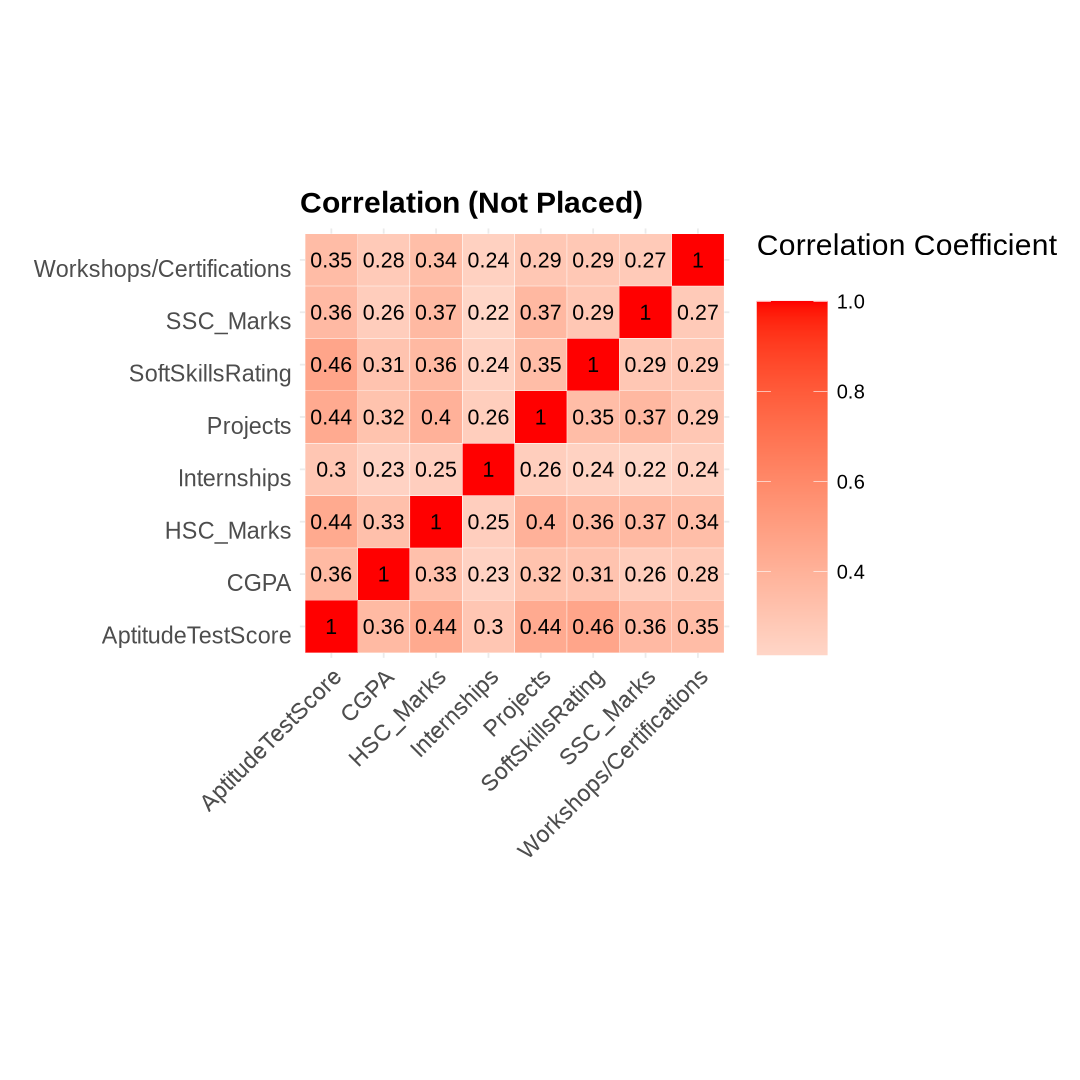

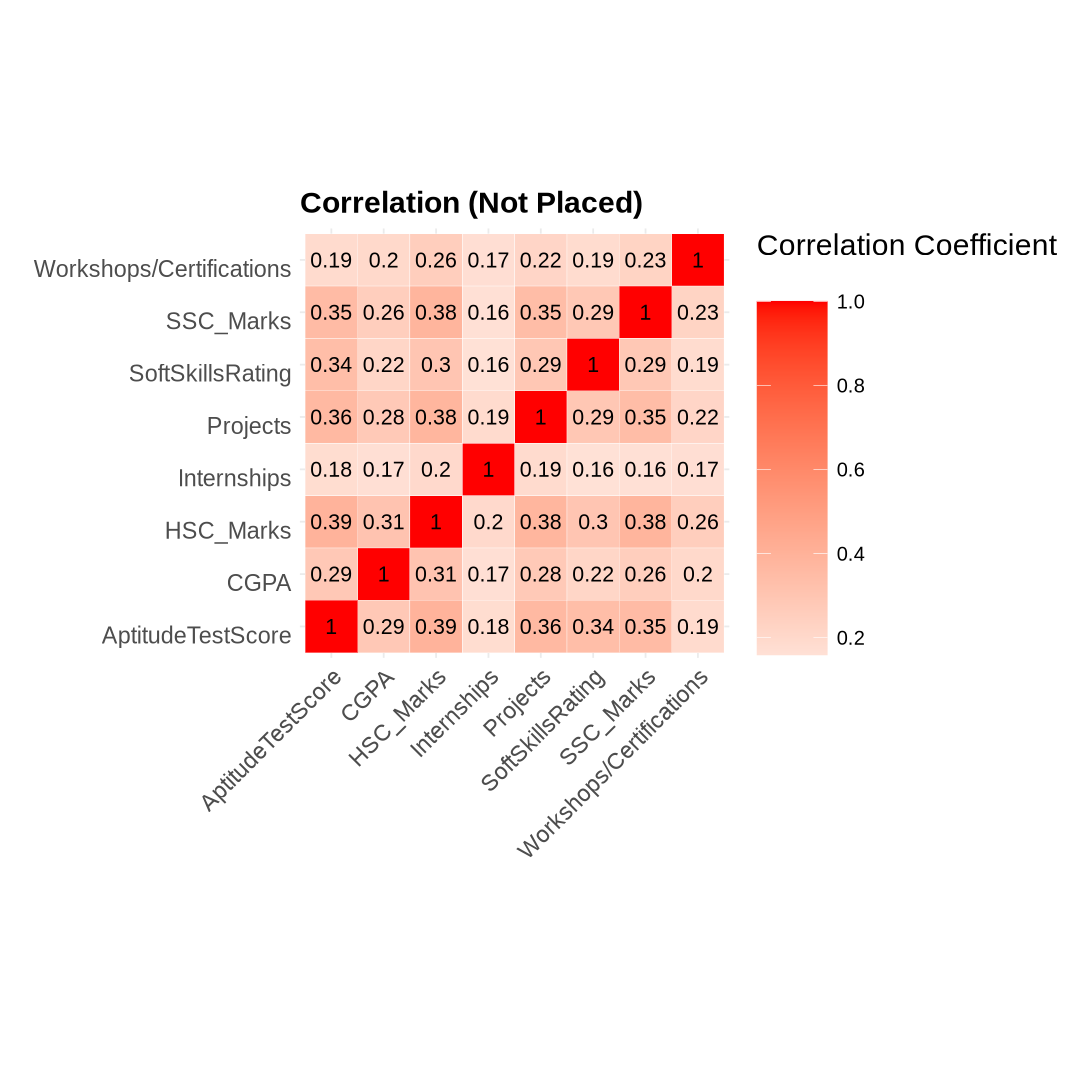

In [8]:
options(repr.plot.width = 9, repr.plot.height = 9)
# Plotting the heatmap
plot_corr_matrix_placed <- 
    corr_matrix_placed %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_gradient2("Correlation Coefficient \n",
                        low = "blue", mid = "white", high = "red", midpoint = 0
    ) +
    labs(title = "Correlation (Not Placed)", x = "", y = "") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 18, face = "bold"),
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
plot_corr_matrix_placed

plot_corr_matrix_not_placed <- 
    corr_matrix_not_placed %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_gradient2("Correlation Coefficient \n",
                        low = "blue", mid = "white", high = "red", midpoint = 0
    ) +
    labs(title = "Correlation (Not Placed)", x = "", y = "") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 18, face = "bold"),
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
plot_corr_matrix_not_placed

### c) Methods: Plan